In [4]:
from tqdm import tqdm
import random
import numpy as np
from timeit import Timer
import matplotlib.pyplot as plt
from pythonds3.basic import Stack
import copy
import requests


In [7]:
#Chapter 5.5 self check 1

def reverse(s):
    if len(s) <= 1:
        return(s)
    else:
        return  s[-1] + reverse(s[:-1])

#self check 2
def remove_white(s):
    return ''.join([ch for ch in s if ch.isalnum()])

def is_pal(s):
    if len(s) <= 1:
        return True 
    
    if s[0] == s[-1]:
        return is_pal(s[1:-1])
    else:
        return False 


Self check chapter 5.11:
The behaviour of the turtle's path different because the order of the moves determine which path the turtle will first try to exhaust before moving on to another path. So changing the order of the moves will change the order of exploration down the possible paths.


# Programming Exercises

In [18]:
# 1. Write a recursive function to compute the factorial of a number 

def factorial(n):
    #base case - when n <= 1 just return 1 
    assert n >= 0
    if n <= 1:
        return 1 
    else:   
        return n * factorial(n-1) 

for i in range(0, 10, 2):
    print(f'{i}!: {factorial(i)}')

0!: 1
2!: 2
4!: 24
6!: 720
8!: 40320


In [9]:
# 2. Write a recursive function to reverse a list 
def reverse_list(lst):
    #base case = when len(lst) == 1, return lst 
    #reducing condition = pass list[:-1] into next call
    if len(lst) == 1:
        return lst 
    else:
        return [lst[-1]] + reverse_list(lst[:-1])
        

In [5]:
# 3. modify the recursive tree program using the following ideas:
# 3.1 modify the thickness of the branches so that as the branch_len gets smaller, line gets thinner
# 3.2 modify the color of the branches so that as the branch_len gets very short it is colored like a leaf 
# 3.3 modify the angle used in turning so that at each branch point the angle is selected at random in some range. 
# 3.4 modify the branch_len recursively so that you subtract a random amount in some range.

# tree.py

Turtle()

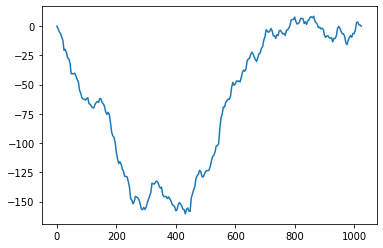

In [11]:
# 4. Find or invent an algorithm for drawing a fractal mountain (2D)
# midpoint displacement method - http://www.mrbertman.com/EE/recursion.pdf
import numpy as np

def midpoint(p1, p2):
    return [(p1[0] + p2[0])/2, (p1[1] + p2[1])/2]

def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)

def vertical_displacement(p1, p2):
    coeff = random.uniform(-1, 1)
    const = 0.25
    return distance(p1, p2) * coeff * const

def midpoint_displace_2d(p1, p2, n, mids, min_len):
    if n > 0 and distance(p1,p2) >= min_len:
        mid = midpoint(p1, p2)
        #displace y
        mid[1] += vertical_displacement(p1, p2)
        mids.append(mid)
        #call midpoint displace between mid point and two ends
        midpoint_displace_2d(p1, mid, n-1, mids, min_len)
        midpoint_displace_2d(p2, mid, n-1, mids, min_len)

n = 8
mids = []
end = 1024
midpoint_displace_2d([0, 0], [end, 0], n, mids, end/2**n)

mids.insert(0, [0, 0])
mids.append([end, 0])
mids = sorted(mids, key=lambda m: m[0])
mids = np.array(mids)

x = mids[:, 0]
y = mids[:, 1]
plt.plot(x, y)


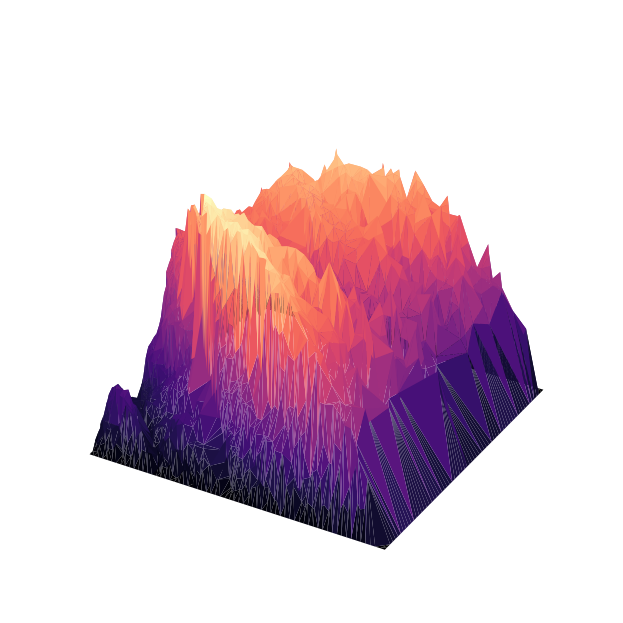

In [12]:
#3D fractal mountain
def midpoint_nd(points, dims=3):
    dim_mids = []
    for dim in range(dims):
        dim_mids.append(sum([p[dim] for p in points]) / len(points))
    return dim_mids

def distance_nd(p1, p2, dims=2):
    return np.sqrt(sum([(p1[dim] - p2[dim])**2 for dim in range(dims)]))

def vertical_displacement_nd(p1, p2, coeff_min=0, coeff_max=1, const=0.05, coeff=None):
    if coeff is None:
        coeff = random.uniform(coeff_min, coeff_max)
    return distance(p1, p2) * coeff * const

def on_edge(pt, end):
    return any([pt[0] == 0, pt[0] == end, pt[1] == 0, pt[1] == end])

def midpoint_displace_3d(p1, p2, p3, p4, n, mids, min_len, end, include_edge=True):
    if n > 0 and distance_nd(p1,p2) >= min_len:
        mid = midpoint_nd([p1, p2])
        #displace y
        mid[2] += vertical_displacement_nd(p1, p2)
        mids.append(mid)
        #including edge points to round out mountain
        if include_edge:
            for pt in [p1, p2, p3, p4]:
                if on_edge(pt, end):
                    if pt not in mids:
                        mids.append(pt)
        
        #call midpoint displace between new quadrilaterals
        midpoint_displace_3d(p1, midpoint_nd([p1, p2]), mid, midpoint_nd([p1, p4]), n-1, mids, min_len, end)
        midpoint_displace_3d(midpoint_nd([p1, p2]), p2, midpoint_nd([p2, p3]), mid, n-1, mids, min_len, end)
        midpoint_displace_3d(mid, midpoint_nd([p2, p3]), p3, midpoint_nd([p3, p4]), n-1, mids, min_len, end)
        midpoint_displace_3d(midpoint_nd([p1, p4]), mid, midpoint_nd([p3, p4]), p4, n-1, mids, min_len, end)

n = 7
end = 1024
mids = []
midpoint_displace_3d([0, 0, 0], [0, end, 0], [end, end, 0], [end, 0, 0], n, mids, end/2**n, end)

#plot 
fig = plt.figure(figsize =(8, 8), dpi=100)
ax = plt.axes(projection ='3d')
mids = np.array(mids)

surf = ax.plot_trisurf(mids[:,0], mids[:, 1], mids[:, 2], cmap='magma',
                    edgecolor='none', linewidth=2)

plt.axis('off')
plt.show()



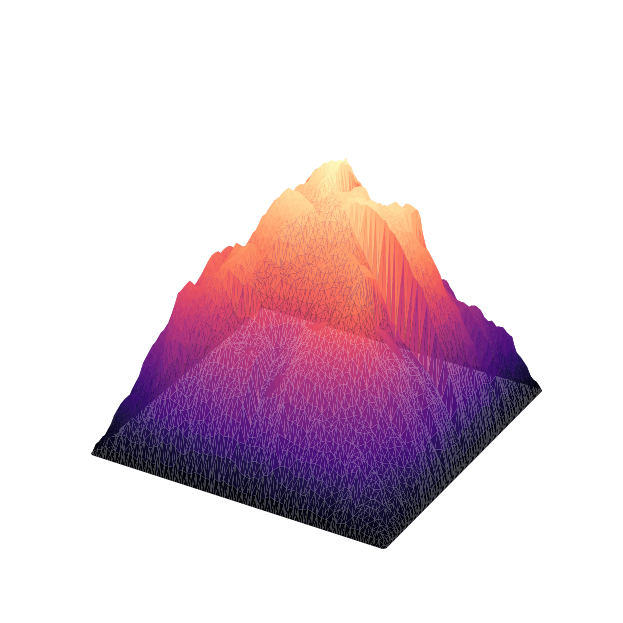

In [13]:
#Diamond Square Algorithm - 3D fractal mountain
def get_coeff(pt, coeffs, end, coeff_min=0, coeff_max=1, const=0.05, displace_once=True):
    if tuple(pt) in coeffs:
        #keep coef the same if already generated or return 0
        if displace_once:
            return 0
        else:
            return coeffs[tuple(pt)]
    else:
        if any([pt[0] == 0, pt[1] == 0, pt[0] == end, pt[1] == end]):
            #if point == edge avoid displacement
            return 0
        coeff = random.uniform(coeff_min, coeff_max) * const
        coeffs.update({tuple(pt): coeff})
        return coeff

def diamond_square(p1, p2, p3, p4, n, mids, min_len, coeffs, end, include_edge=True):
    if n > 0 and distance_nd(p1,p2) >= min_len:
        mid = midpoint_nd([p1, p2, p3, p4])
        #displace y
        mid[2] += vertical_displacement_nd(p1, p2, coeff=get_coeff(mid, coeffs, end))
        mids.append(mid)
        #additional step: also displace the midpoints zs! 
        E = midpoint_nd([p1, p2]) #E = midpoint p1, p2
        E[2] += vertical_displacement_nd(p1, p2, coeff=get_coeff(E, coeffs, end))
        F = midpoint_nd([p2, p3]) #F = midpoint p2, p3
        F[2] += vertical_displacement_nd(p2, p3, coeff=get_coeff(F, coeffs, end))
        G = midpoint_nd([p3, p4]) #G = midpoint p3, p4
        G[2] += vertical_displacement_nd(p3, p4, coeff=get_coeff(G, coeffs, end))
        H = midpoint_nd([p1, p4]) #H = midpoint p1, p4
        H[2] += vertical_displacement_nd(p1, p4, coeff=get_coeff(H, coeffs, end))

        if include_edge:
            for pt in [E, F, G, H]:
                if on_edge(pt, end):
                    if pt not in mids:
                        mids.append(pt)

        #call midpoint displace between new quadrilaterals
        diamond_square(p1, E, mid, H, n-1, mids, min_len, coeffs, end)
        diamond_square(E, p2, F, mid, n-1, mids, min_len, coeffs, end)
        diamond_square(mid, F, p3, G, n-1, mids, min_len, coeffs, end)
        diamond_square(H, mid, G, p4, n-1, mids, min_len, coeffs, end)

n = 7
end = 1024
mids = []
#coeff matrix to counter the fact that b/c quadrilateral transformations don't know what each other are doing, so square transforms cause
#discrepancies in final z
coeffs = {}
diamond_square([0, 0, 0], [0, end, 0], [end, end, 0], [end, 0, 0], n, mids, end/2**n, coeffs, end)

#plot 
fig = plt.figure(figsize =(8, 8), dpi=100)
ax = plt.axes(projection ='3d')
mids = np.array(mids)

surf = ax.plot_trisurf(mids[:,0], mids[:, 1], mids[:, 2], cmap='magma',
                    edgecolor='none', linewidth=2)

plt.axis('off')
plt.show()

In [14]:
# 5. Write a recursive function to compute the Fibonacci sequence. 
# How does the performance of the recursive function compare to that of an iterative version?

def iterative_fib(n):
    assert n > 0
    fibs = [0, 1]
    for _ in range(n-2):
        fibs.append(fibs[-1] + fibs[-2])
    return fibs[n-1]

def recursive_fib(n):
    #base case is when n == 1 or n == 0 (starting numbers)
    assert n > 0
    if n == 1:
        return 0
    elif n == 2:
        return 1
    else:
        return recursive_fib(n-1) + recursive_fib(n-2)

for i in range(1, 12):
    assert recursive_fib(i) == iterative_fib(i)


100%|██████████| 30/30 [00:09<00:00,  3.05it/s] 


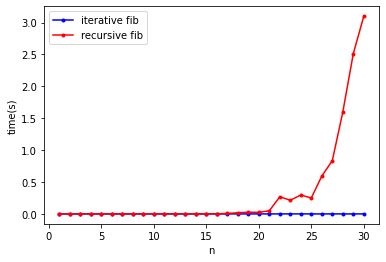

In [15]:
#Recursive vs iterative performance comparison 
X = []
Y1 = []# pystack push
Y2 = [] # llstack push
number = 10
for size in tqdm(range(1, 31)):
    #test push 
    t1 = Timer(f"iterative_fib({size})", "from __main__ import iterative_fib")
    Y1.append(t1.timeit(number=number))
    t2 = Timer(f"recursive_fib({size})", "from __main__ import recursive_fib")
    Y2.append(t2.timeit(number=number))
    X.append(size)

plt.plot(X, Y1, color='blue', marker='.', label='iterative fib')
plt.plot(X, Y2, color='red', marker='.', label='recursive fib')

plt.xlabel('n')
plt.ylabel('time(s)')
plt.legend()

### Comparison between recursive and iterative fib:
From the short experiment, we can see that recursive fib's run time increases exponentially. This is because in recursion, we do a lot of repeated calculations (such as in recursive_fib(5), recursive_fib(4) and recursive_fib(3) will be called in the initial function call, which contains repeats such as in recursive_fib(4), recursive_fib(3) is called again.) To add to that, calling functions is an expensive operation in python, b/c of the creation of a new stack frame to be executed. In comparison, iterative_fib is a form of dynamic programming, where we use previous results to obtain the current iteration's result, resulting in much better run time.

In [247]:
# 6. Implement a solution to the Tower of Hanoi using three stacks to keep track of the disks.

def move_disk(from_stack, to_stack):
    if not to_stack.is_empty():
        assert from_stack.peek() < to_stack.peek()
    print(f'moving from {from_stack.name} to {to_stack.name}')
    to_stack.push(from_stack.pop())

def print_stacks(stacks):
    stack_dict = {}
    total = 0
    for s in stacks:
        stack_dict.update({s.name: copy.deepcopy(s)})
        total += s.size()
    stack_dict['total'] = total
    print('A\t\tB\t\tC')
    while stack_dict['total']:
        curr_str = ''
        for name in ['A', 'B', 'C']:
            if not stack_dict[name].is_empty():
                curr_str = curr_str + str(stack_dict[name].pop()) + '\t\t'
                stack_dict['total'] -= 1
            else:
                curr_str = curr_str + '||' + '\t\t'
        print(curr_str)

def move_tower(n_disks, from_stack, to_stack, with_stack, print_moves=False):
    if n_disks >= 1:
        #move tower of n-1 to with_stack, to free up bottom disk at from_stack
        move_tower(n_disks-1, from_stack, with_stack, to_stack, print_moves=print_moves)
        #move_disk from from_stack to to_stack
        move_disk(from_stack, to_stack)
        if print_moves:
            print_stacks([from_stack, to_stack, with_stack])
        #move remaining tower from with_stack back to to_stack
        move_tower(n_disks-1, with_stack, to_stack, from_stack, print_moves=print_moves)

def hanoi_with_stacks(n, print_moves=True):
    #initialize stacks
    stacks = [Stack() for _ in range(3)]
    for i, name in enumerate(['A', 'C', 'B']):
        stacks[i].name = name

    for i in range(n, 0, -1):
        stacks[0].push(i)

    if print_moves:
        print_stacks(stacks)
    move_tower(n, *stacks, print_moves=print_moves)

hanoi_with_stacks(2)

A		B		C
1		||		||		
2		||		||		
moving from A to B
A		B		C
2		1		||		
moving from A to C
A		B		C
||		1		2		
moving from B to C
A		B		C
||		||		1		
||		||		2		


In [29]:
# 7. Using the turtle graphics module, write a recursive program to display a Hilbert curve.
# hilbert.py

In [81]:
# 8. Using the turtle graphics module, write a recursive program to display a Koch snowflake.
# koch_snowflake.py

In [220]:
# Write a program to solve the following problem: You have two jugs: a 4-gallon jug and a 3-gallon jug. 
# Neither of the jugs have markings on them. There is a pump that can be used to fill the jugs with water. 
# How can you get exactly two gallons of water in the 4-gallon jug?
class Jug:
    def __init__(self, capacity=0):
        self.capacity = capacity 
        self.current = 0
    
    def __gt__(self, other):
        #pour all of self into other 
        rem = other.capacity - other.current 
        pour_in = min(self.current, rem)
        self.current -= pour_in
        other.current += pour_in

    def empty(self):
        self.current = 0
    
    def fill(self):
        self.current = self.capacity

    def is_empty(self):
        return self.current == 0

    def is_full(self):
        return self.capacity == self.current 


def jug_problem(a, b, mem_dict, rem=2):
    #use memoization to store visited states to prevent infinite recursion
    assert rem <= a.capacity
    #store state as string 
    state_string = f'{a.current} {b.current}'
    if state_string in mem_dict:
        print(f'a={a.capacity}, b={b.capacity}, rem={rem} has no solution')
        return False 
    else:
        mem_dict.update({state_string: None})

    if any([a.current == rem, b.current == rem, a.capacity == rem, b.capacity == rem]):
        #if any of these are satisfied then either the problem is solved or just requires one more move.
        #print(f'a={a.capacity}, b={b.capacity}, rem={rem} completed')
        return True
    else:
        if a.is_empty():
            a.fill()
        a > b
        if b.is_full():
            b.empty()
        
        return jug_problem(a, b, mem_dict, rem=rem)

#Alternative solution - use recursion to visit ALL POSSIBLE MOVES - (no need to use class, just store a and b capacity)
def jug_problem_2(a_cap, b_cap, a, b, mem_dict, rem=2):
    if (a,b) in mem_dict:
        return False
    else:
        mem_dict.update({(a,b): None})
    
    if (a == rem and b == 0) or (b == rem and a == 0):
        #if any of these are satisfied then either the problem is solved or just requires one more move.
        #print(f'a={a.capacity}, b={b.capacity}, rem={rem} completed')
        return True
    else:
        a_to_b = min(b_cap - b, a)
        b_to_a = min(a_cap - a, b)
        #remember to return!
        return(
        #fill a
        jug_problem_2(a_cap, b_cap, a_cap, b, mem_dict, rem=rem) or
        #fill b
        jug_problem_2(a_cap, b_cap, a, b_cap, mem_dict, rem=rem) or
        #empty a
        jug_problem_2(a_cap, b_cap, 0, b, mem_dict, rem=rem) or
        #empty b 
        jug_problem_2(a_cap, b_cap, a, 0, mem_dict, rem=rem) or
        #pour a in to b
        jug_problem_2(a_cap, b_cap, a - a_to_b, b + a_to_b, mem_dict, rem=rem) or
        #pour b in to a
        jug_problem_2(a_cap, b_cap, a + b_to_a, b - b_to_a, mem_dict, rem=rem)
        )


In [224]:
#test jug problem 
def test_jug_problem(n):
    for i in range(1, n+1):
        for j in range(1, n+1):
            for k in range(1, i+1):
                assert jug_problem(Jug(i), Jug(j), {}, rem=k) == jug_problem_2(i, j, 0, 0, {}, rem=k)

test_jug_problem(5)

a=2, b=2, rem=1 has no solution
a=2, b=4, rem=1 has no solution
a=3, b=3, rem=1 has no solution
a=3, b=3, rem=2 has no solution
a=4, b=2, rem=1 has no solution
a=4, b=2, rem=3 has no solution
a=4, b=4, rem=1 has no solution
a=4, b=4, rem=2 has no solution
a=4, b=4, rem=3 has no solution
a=5, b=5, rem=1 has no solution
a=5, b=5, rem=2 has no solution
a=5, b=5, rem=3 has no solution
a=5, b=5, rem=4 has no solution


In [240]:
# 11. Write a program that solves the following problem: Three missionaries and three cannibals come to a river 
# and find a boat that holds two people. Everyone must get across the river to continue on the journey. 
# However, if the cannibals ever outnumber the missionaries on either bank, the missionaries will be eaten. 
# Find a series of crossings that will get everyone safely to the other side of the river.

def river_crossing_problem(n=3, x_c=3, x_m=3, b_c=0, b_m=0, y_c=0, y_m=0, seq=''):
    """
    x_m : monks at bank 1
    x_c : cannibals at bank 1
    b_m : monks on boat
    b_c : cannibals on boat
    y_m : monks at bank 2
    y_c : cannibals at bank 2
    """

    #could be less restrictive here by adding variable to indicate which bank boat is at, so there is more 
    #flexibility in loading, but this is just a little simpler.
    if x_m < x_c or y_m < y_c or b_m + b_c > 2 or list(filter(lambda x: x < 0, [x_c, x_m, b_m, b_c, y_c, y_m])):
        #missionary will be eaten or more than two people on boat or negative values occurring
        return False 
    
    if y_c == n and y_m == n:
        print(f'solution for n = {n}: ')
        print(seq)
        return True 

    #options
    return(
    #load cannibal
    river_crossing_problem(n, x_c-1, x_m, b_c+1, b_m, y_c, y_m, seq=seq+'load c, ') or 
    #load missionary
    river_crossing_problem(n, x_c, x_m-1, b_c, b_m+1, y_c, y_m, seq=seq+'load m, ') or
    #offload cannibal
    river_crossing_problem(n, x_c, x_m, b_c-1, b_m, y_c+1, y_m, seq=seq+'off c, ') or
    #offload missionary
    river_crossing_problem(n, x_c, x_m, b_c, b_m-1, y_c, y_m+1, seq=seq+'off m, ')
    )


In [243]:
def test_river_crossing_problem(n):
    assert river_crossing_problem(n=n, x_c=n, x_m=n)
    
test_river_crossing_problem(3)

solution for n = 3: 
load c, load m, off m, load c, off c, load m, off m, load c, off c, load m, off m, off c, 


In [ ]:
# 12. Modify the Tower of Hanoi program using turtle graphics to animate the movement of the disks. 
# Hint: You can make multiple turtles and have them shaped like rectangles.
# turtle_hanoi.py

In [421]:
# 13. Write a program that prints out Pascal’s triangle. 
# Your program should accept a parameter that tells how many rows of the triangle to print.

def get_rows(n, res):
    if n == 1:
        res.append([1])
        return res 
    else:
        #this recurring call will go down to n == 1 first and append [1]
        res = get_rows(n-1, res)
        #for each last row, insert pseudo 0s at beginning and end
        last_row = res[-1]
        last_row.insert(0, 0)
        last_row.append(0)
        #find new row
        new_row = []
        for i in range(len(last_row)-1):
            new_row.append(last_row[i] + last_row[i+1])
        #remove pseudo 0s
        last_row.pop(0)
        last_row.pop()
        res.append(new_row)
        return res

def find_max_n_digits(rows):
    last_row = rows[-1]
    max_digits = 0
    for n in last_row:
        max_digits = max(max_digits, len(str(n)))
    return max_digits
    
def pascals_triangle(n):
    rows = get_rows(n, [])
    #adjusting n spaces kind of makes it look better at higher ns - ensures values are always semi-inbetween parent values
    space = ' ' * (find_max_n_digits(rows))
    for i, r in enumerate(rows):
        row_string = space.join(list(map(str, r)))
        print(space * (n - i) + row_string)



In [424]:
pascals_triangle(7)

              1
            1  1
          1  2  1
        1  3  3  1
      1  4  6  4  1
    1  5  10  10  5  1
  1  6  15  20  15  6  1


In [549]:
# 14. Suppose you are a computer scientist/art thief who has broken into a major art gallery. 
# All you have with you to haul out your stolen art is your knapsack which only holds 𝑊 pounds of art, 
# but for every piece of art you know its value and its weight. Write a dynamic programming function to help you 
# maximize your profit. Here is a sample problem for you to use to get started: Suppose your knapsack can hold a total weight of 20. 
# You have 5 items as follows:

#item     weight      value
#  1        2           3
#  2        3           4
#  3        4           8
#  4        5           8
#  5        9          10


def knapsack_problem(W=20, items=None, unique=True):
  """ 
  W: capacity of knapsack
  items: possible items to bring - expect list of tuples (weight, value)
  unique: whether it's okay to bring multiple of the same item
  """

  def unique_constraint(curr_item, last_items, w, unique=unique):
    #curr_item = (weight, val, idx)
    if not unique:
      return True 
    else:
      return curr_item[-1] not in [item[-1] for item in last_items[w-curr_item[0]]]

  max_vals = []
  #for each max_val save the items that are included in intermediate solution
  last_items = []
  for w in tqdm(range(W+1)):
    #for each weight constraint w find the best possible value - similar to coin change problem
    max_val = 0
    last_item = []
    #recording idx here as well in case there are cases where there are items that share the same values
    eligible_items = [(weight, val, idx) for idx, (weight, val) in enumerate(items) if weight <= w]
    for weight,val,idx in eligible_items:
      if max_vals[w-weight] + val > max_val and unique_constraint((weight,val,idx), last_items, w, unique=unique):
        max_val = max_vals[w-weight] + val 
        last_item = last_items[w-weight] + [(weight, val, idx)]
    max_vals.append(max_val)
    last_items.append(last_item)
    #during unique, if all items have been selected then break the loop
    if len(last_item) == len(items) and unique:
      break

  assert sum([item[-1] for item in last_items[-1]]) <= W
  return max_vals[-1], last_items[-1]



In [544]:
def get_test_cases():
    #simple script to get some defined test cases
    tests = []
    for i in range(1, 9):
        test = {}
        for f in ['c', 'w', 'p', 's']:
            url = f'https://people.math.sc.edu/Burkardt/datasets/knapsack_01/p0{i}_{f}.txt'
            r = requests.get(url)
            text = r.text 
            test[f] = [t.strip() for t in text.split('\n') if t != '']
        tests.append(test)
    return tests

test_cases = get_test_cases()

In [550]:
max_val, solution = knapsack_problem(W=20, items=[(2,3), (3,4), (4,8), (5,8), (9, 10)], unique=False)
print(max_val, solution)

max_val, solution = knapsack_problem(W=20, items=[(2,3), (3,4), (4,8), (5,8), (9, 10)], unique=True)
print(max_val, solution)

#other test cases
for test in test_cases:
    #format inputs
    W = int(test['c'][0])
    items = [(int(w),int(p)) for w,p in zip(test['w'], test['p'])]
    max_val, solution = knapsack_problem(W=W, items=items, unique=True)
    #format solution
    f_sol = [0] * len(items)
    for s in solution:
        f_sol[s[-1]] = 1
    
    assert f_sol == list(map(int, test['s']))



100%|██████████| 21/21 [00:00<00:00, 51842.49it/s]


40 [(4, 8, 2), (4, 8, 2), (4, 8, 2), (4, 8, 2), (4, 8, 2)]


100%|██████████| 21/21 [00:00<00:00, 58177.27it/s]


29 [(4, 8, 2), (5, 8, 3), (9, 10, 4), (2, 3, 0)]


100%|██████████| 6404181/6404181 [03:03<00:00, 34960.22it/s]


In [589]:
# above solution essentially does the dp table solution, but slightly less elegant... - but can accomodate problems where
# multiple items can be held
def knapsack_problem_2(W=None, items=[]):
    #table style solution to 0/1 knapsack
    #init table
    tb = np.zeros((len(items), W+1))
    #essentially, each row indicates whether to take an item at each weight limit 
    for i in tqdm(range(len(items))):
        for j in range(W+1):
            #consider tb[i][j]
            item_weight = items[i][0]
            item_value = items[i][1]
            #if current item's weight is less than or equal to weight constraint 
            if item_weight <= j:
                if i == 0:
                    #can only take one of each item so first row can only equal to item value
                    tb[i][j] = item_value
                else:
                    #take the max of either not taking the item, or taking the item at this stage
                    tb[i][j] = max(tb[i-1][j], tb[i-1][j-item_weight] + item_value)
            else:
                if i == 0:
                    tb[i][j] = 0
                else:
                    #if can't take another item then just take the max value at this weight constraint without this itme (row above)
                    tb[i][j] = tb[i-1][j]

    return tb[-1][-1]



In [590]:
#test that this knapsack is valid as well
for test in test_cases:
    #format inputs
    W = int(test['c'][0])
    items = [(int(w),int(p)) for w,p in zip(test['w'], test['p'])]
    max_val, solution = knapsack_problem(W=W, items=items, unique=True)
    max_val_2 = knapsack_problem_2(W=W, items=items)
    assert max_val == max_val_2
    

100%|██████████| 24/24 [03:50<00:00,  9.60s/it]


In [5]:
# 15. Suppose that you want to transform the word “algorithm” into the word “alligator.” 
# For each letter you can either copy the letter from one word to another at a cost of 5, 
# you can delete a letter at cost of 20, or insert a letter at a cost of 20. 
# The total cost to transform one word into another is used by spell check programs to provide suggestions 
# for words that are close to one another. Use dynamic programming techniques to develop an algorithm that gives you 
# the smallest edit distance between any two words.
def string_edit_distance(str_1='algorithm', str_2='alligator', swap_cost=5, insertion_cost=20, deletion_cost=20):
    #init table
    #subproblems - what is the cost to transform 1 substring to another substring?
    
    #loop from len(str)+1 - allow the possiblity of indels for first letter and possibility of empty string
    tb = np.zeros((len(str_1)+1, len(str_2)+1))
    for i in range(len(str_1)+1):
        for j in range(len(str_2)+1):
            if i == 0:
                #first string is empty and so is just j * INSERTIONS
                tb[i][j] = j * insertion_cost
            elif j == 0:
                #second string is empty and so is just i * DELETEIONS
                tb[i][j] = i * deletion_cost
            
            #if curr char is the same, then just take the previous diagonal (no indels and no swaps!)
            #in previous code the same char condition is too restrictive... 
            #same char can occur even if substr_1 and substr_2 are of 
            #different lens
            elif str_1[i-1] == str_2[j-1]:
                tb[i][j] = tb[i-1][j-1]

            else:
                tb[i][j] = min(
                    tb[i][j-1] + insertion_cost, #insertion -- moving along j axis 
                    tb[i-1][j] + deletion_cost, #deletion -- moving along i axis
                    tb[i-1][j-1] + swap_cost  #copying a letter - taking diagonal (no indels) and adding swap_cost
                )
    return tb
                



In [8]:
string_edit_distance('algorithm', 'alligator', swap_cost=5, insertion_cost=20, deletion_cost=20)

array([[  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.],
       [ 20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.],
       [ 40.,  20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.],
       [ 60.,  40.,  20.,   5.,  25.,  40.,  60.,  80., 100., 120.],
       [ 80.,  60.,  40.,  25.,  10.,  30.,  45.,  65.,  80., 100.],
       [100.,  80.,  60.,  45.,  30.,  15.,  35.,  50.,  70.,  80.],
       [120., 100.,  80.,  65.,  45.,  35.,  20.,  40.,  55.,  75.],
       [140., 120., 100.,  85.,  65.,  50.,  40.,  20.,  40.,  60.],
       [160., 140., 120., 105.,  85.,  70.,  55.,  40.,  25.,  45.],
       [180., 160., 140., 125., 105.,  90.,  75.,  60.,  45.,  30.]])